# Celda 1: Instalación de librerías necesarias

In [1]:
#!pip install numpy matplotlib qiskit qiskit-aer

# Celda 2: Importación de librerías

In [2]:
import numpy as np
import math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator

# Celda 3: Funciones auxiliares

In [3]:

def convert_to_mixed_radix(x, moduli):
    """
    Convierte un número entero en su representación de base mixta según los módulos dados.

    Args:
        x (int): Número entero que se desea convertir.
        moduli (list): Lista de módulos que definen las bases mixtas.

    Returns:
        tuple: Representación del número en base mixta (una tupla de dígitos).
    """
    digits = []  # Lista para almacenar los dígitos de la representación mixta.
    remainder = x  # Inicializar el número restante a convertir.

    # Iterar sobre los módulos en orden inverso para calcular los dígitos.
    for m in reversed(moduli):
        digits.insert(0, remainder % m)  # Calcular el dígito correspondiente al módulo actual.
        remainder = remainder // m  # Actualizar el resto dividiendo por el módulo actual.

    return tuple(digits)  # Devolver la representación como una tupla.

def mixed_radix_to_int(t, moduli):
    """
    Reconstruye un número entero a partir de su representación en base mixta.

    Args:
        t (tuple): Representación en base mixta (tupla de dígitos).
        moduli (list): Lista de módulos que definen las bases mixtas.

    Returns:
        int: Número entero reconstruido.
    """
    # Inicializar el valor reconstruido
    value = 0

    # Iterar sobre los dígitos y módulos en orden directo
    for digit, m in zip(t, moduli):
        value = value * m + digit  # Acumular el valor usando la base mixta

    return value

# Ajuste para manejar listas de tuplas
def process_hidden_subgroup(hidden_subgroup, moduli):
    """
    Convierte una lista de representaciones en base mixta a números enteros.

    Args:
        hidden_subgroup (list): Lista de tuplas que representan el subgrupo oculto.
        moduli (list): Lista de módulos que definen las bases mixtas.

    Returns:
        list: Lista de números enteros reconstruidos.
    """
    return [mixed_radix_to_int(item, moduli) for item in hidden_subgroup]

# Celda 4: Implementación de la QFT personalizada

In [4]:
def qft_group(moduli):
    """
    Construye un circuito que aplica la QFT optimizada a un grupo definido por sus módulos.
    
    Args:
        moduli (list): Lista de módulos del grupo.
    
    Returns:
        QuantumCircuit: Circuito cuántico que implementa la QFT optimizada.
    """
    bits_per_factor = [math.ceil(math.log2(m)) for m in moduli]
    total_qubits = sum(bits_per_factor)
    qc = QuantumCircuit(total_qubits)
    
    # Aplicar Hadamard a todos los qubits en paralelo
    for i in range(total_qubits):
        qc.h(i)
    
    # Aplicar rotaciones de fase por grupos de módulos
    qubit_offset = 0
    for idx, m in enumerate(moduli):
        n_qubits = bits_per_factor[idx]
        
        # Aplicar rotaciones dentro de este grupo de qubits
        for layer in range(1, n_qubits):
            for i in range(n_qubits - layer):
                j = i + layer
                angle = 2 * np.pi / m * (2 ** layer)
                qc.cp(angle, qubit_offset + j, qubit_offset + i)
        
        qubit_offset += n_qubits
    
    return qc


# Celda 5: Implementación del oráculo Uf

In [5]:
def Uf(qc, control_reg, target_reg, f_mapping, moduli):
    """
    Implementa el oráculo cuántico Uf para el problema del subgrupo oculto.
    
    Args:
        qc (QuantumCircuit): Circuito cuántico al que se añade el oráculo.
        control_reg (QuantumRegister): Registro de control.
        target_reg (QuantumRegister): Registro objetivo.
        f_mapping (dict): Mapeo entre índices y valores objetivo.
        moduli (list): Lista de módulos del grupo.
        
    Returns:
        QuantumCircuit: Circuito con el oráculo añadido.
    """
    bits_per_factor = [math.ceil(math.log2(m)) for m in moduli]

    for idx, f_val in f_mapping.items():
        rep = convert_to_mixed_radix(idx, moduli)
        control_str = ''.join([format(d, f'0{bp}b') for d, bp in zip(rep, bits_per_factor)])
        target_str = format(f_val, f'0{len(target_reg)}b')

        # Configurar controles en estado 0 aplicando puertas X cuando sea necesario
        for j, bit in enumerate(control_str):
            if bit == '0':
                qc.x(control_reg[j])

        # Aplicar XOR entre el valor actual del registro objetivo y f(g)
        # Esto se implementa con puertas X controladas (CNOT)
        for k, bit in enumerate(target_str):
            if bit == '1':
                qc.mcx(control_reg[:], target_reg[k])

        # Restaurar los controles a su estado original
        for j, bit in enumerate(control_str):
            if bit == '0':
                qc.x(control_reg[j])

    return qc


# Celda 6: Construcción del circuito HSP

In [6]:
def hsp_solver(f_mapping, moduli, n_target):
    """
    Construye el circuito cuántico completo para resolver el problema del subgrupo oculto (HSP)
    utilizando una QFT personalizada.
    
    Args:
        f_mapping (dict): Mapeo entre índices y valores objetivo.
        moduli (list): Lista de módulos del grupo.
        n_target (int): Número de qubits en el registro objetivo.
    
    Returns:
        QuantumCircuit: Circuito cuántico completo.
    """
    bits_per_factor = [math.ceil(math.log2(m)) for m in moduli]
    n_control = sum(bits_per_factor)

    # Crear registros cuánticos y clásicos
    control_reg = QuantumRegister(n_control, 'control')
    target_reg = QuantumRegister(n_target, 'target')
    c_control = ClassicalRegister(n_control, 'c_control')
    c_target = ClassicalRegister(n_target, 'c_target')

    qc = QuantumCircuit(control_reg, target_reg, c_control, c_target)

    # Paso 1: Aplicar la QFT personalizada en lugar de la superposición inicial
    qft_circuit = qft_group(moduli)
    qc.append(qft_circuit.to_gate(), control_reg)
    
    # Paso 2: Aplicar el oráculo Uf
    Uf(qc, control_reg, target_reg, f_mapping, moduli)

    # Paso 3: Medir registro objetivo
    qc.measure(target_reg, c_target)

    # Paso 4: Aplicar la QFT inversa al registro de control
    qc.append(qft_circuit.inverse().to_gate(), control_reg)

    # Paso 5: Medir registro de control
    qc.measure(control_reg, c_control)

    return qc


# Celda 7: Extracción del subgrupo Oculto

In [7]:
def extract_hidden_subgroup_improved(counts, moduli, tolerance=0.15, frequency_threshold=0.03):
    """
    Extrae el subgrupo oculto a partir de los resultados de medición en un circuito cuántico,
    sin generar todos los elementos del grupo y considerando la frecuencia de las mediciones.
    
    Args:
        counts (dict): Diccionario con los resultados de medición (bitstrings y sus frecuencias).
        moduli (list): Lista de módulos que definen la estructura del grupo.
        tolerance (float): Tolerancia para determinar la validez de las fases.
        frequency_threshold (float): Umbral de frecuencia relativa para considerar una medición.
    
    Returns:
        list: Lista ordenada de elementos que forman el subgrupo oculto.
    """
    # Calcular el número total de mediciones
    total_counts = sum(counts.values())
    
    # Filtrar mediciones por frecuencia y convertir a representación mixta
    S = []  # Lista de tuplas (representación mixta, frecuencia relativa)
    bits_per_factor = [math.ceil(math.log2(m)) for m in moduli]
    
    for key, count in counts.items():
        # Calcular la frecuencia relativa
        frequency = count / total_counts
        
        # Filtrar por umbral de frecuencia
        if frequency >= frequency_threshold:
            parts = key.split()
            if len(parts) > 0:
                control_str = parts[0]
                control_int = int(control_str, 2)
                
                # Conversión a representación mixta
                mixed_rep = []
                remaining = control_int
                for m, bits in zip(reversed(moduli), reversed(bits_per_factor)):
                    mask = (1 << bits) - 1
                    mixed_rep.insert(0, remaining & mask)
                    remaining >>= bits
                
                # Almacenar la representación mixta junto con su frecuencia
                S.append((tuple(mixed_rep), frequency))
    
    # Ordenar las mediciones por frecuencia (de mayor a menor)
    S.sort(key=lambda x: x[1], reverse=True)
    
    # Extraer solo las representaciones mixtas
    S_reps = [rep for rep, _ in S]
    
    # Encontrar generadores del subgrupo oculto
    H_generators = []
    
    # Función para verificar si un elemento satisface las condiciones de fase
    def is_valid_element(element):
        for rep in S_reps:
            phase = sum(element[k] * rep[k] / moduli[k] for k in range(len(moduli)))
            if abs(phase - round(phase)) > tolerance:
                return False
        return True
    
    # Buscar generadores simples (con un solo componente no nulo)
    for i in range(len(moduli)):
        for value in range(1, moduli[i]):
            # Crear un candidato a generador
            candidate = [0] * len(moduli)
            candidate[i] = value
            candidate = tuple(candidate)
            
            if is_valid_element(candidate):
                H_generators.append(candidate)
    
    # Si no se encontraron generadores, probar con combinaciones más complejas
    if not H_generators:
        # Probar con combinaciones de dos componentes no nulos
        for i in range(len(moduli)):
            for j in range(i+1, len(moduli)):
                for vi in range(1, moduli[i]):
                    for vj in range(1, moduli[j]):
                        candidate = [0] * len(moduli)
                        candidate[i] = vi
                        candidate[j] = vj
                        candidate = tuple(candidate)
                        
                        if is_valid_element(candidate):
                            H_generators.append(candidate)
    
    
    
    # Si aún no hay generadores, el subgrupo es trivial (solo el elemento identidad)
    if not H_generators:
        return [(0,) * len(moduli)]
    
    # Generar el subgrupo completo a partir de los generadores
    H = {(0,) * len(moduli)}  # Empezar con el elemento identidad
    
    # Función para sumar elementos en el grupo (módulo los módulos correspondientes)
    def group_add(a, b):
        return tuple((a[i] + b[i]) % moduli[i] for i in range(len(moduli)))
    
    # Generar el subgrupo completo usando los generadores
    old_size = 0
    while old_size < len(H):
        old_size = len(H)
        new_elements = set()
        
        for g in H:
            for h in H_generators:
                new_elements.add(group_add(g, h))
        
        H.update(new_elements)
    
    return sorted(list(H))


# Celda 8: Ejecución del circuito y extracción del subgrupo oculto

In [15]:
# Número total de elementos
total_elements = 2**14

# Secuencia base
base_sequence = [0, 1, 2, 3]

# Definición de datos periódicos y parámetros iniciales

data2= (base_sequence * (total_elements // len(base_sequence))) + base_sequence[:total_elements % len(base_sequence)]# Subgrupo costante en clases laterales 
moduli = (2,2,2,2,2,2,2,2,2,2,2,2,2,2) 
n_target = math.ceil(math.log2(max(data2) + 1))
f_mapping = dict(enumerate(data2))
print(f_mapping)
# Construcción del circuito HSP
qc = hsp_solver(f_mapping, moduli, n_target)

# Simulación del circuito usando AerSimulator de Qiskit
simulator = AerSimulator()
transpiled_qc = transpile(qc, simulator)
result = simulator.run(transpiled_qc,shots=10000).result()
counts = result.get_counts()
print(counts)
# Extracción del subgrupo oculto a partir de los resultados medidos
hidden_subgroup = extract_hidden_subgroup_improved(counts, moduli)

# Conversión del subgrupo oculto a enteros
hidden_subgroup_int = process_hidden_subgroup(hidden_subgroup, moduli)

print("Subgrupo detectado (enteros):", hidden_subgroup_int)
print("Subgrupo detectado:", hidden_subgroup)



{0: 0, 1: 1, 2: 2, 3: 3, 4: 0, 5: 1, 6: 2, 7: 3, 8: 0, 9: 1, 10: 2, 11: 3, 12: 0, 13: 1, 14: 2, 15: 3, 16: 0, 17: 1, 18: 2, 19: 3, 20: 0, 21: 1, 22: 2, 23: 3, 24: 0, 25: 1, 26: 2, 27: 3, 28: 0, 29: 1, 30: 2, 31: 3, 32: 0, 33: 1, 34: 2, 35: 3, 36: 0, 37: 1, 38: 2, 39: 3, 40: 0, 41: 1, 42: 2, 43: 3, 44: 0, 45: 1, 46: 2, 47: 3, 48: 0, 49: 1, 50: 2, 51: 3, 52: 0, 53: 1, 54: 2, 55: 3, 56: 0, 57: 1, 58: 2, 59: 3, 60: 0, 61: 1, 62: 2, 63: 3, 64: 0, 65: 1, 66: 2, 67: 3, 68: 0, 69: 1, 70: 2, 71: 3, 72: 0, 73: 1, 74: 2, 75: 3, 76: 0, 77: 1, 78: 2, 79: 3, 80: 0, 81: 1, 82: 2, 83: 3, 84: 0, 85: 1, 86: 2, 87: 3, 88: 0, 89: 1, 90: 2, 91: 3, 92: 0, 93: 1, 94: 2, 95: 3, 96: 0, 97: 1, 98: 2, 99: 3, 100: 0, 101: 1, 102: 2, 103: 3, 104: 0, 105: 1, 106: 2, 107: 3, 108: 0, 109: 1, 110: 2, 111: 3, 112: 0, 113: 1, 114: 2, 115: 3, 116: 0, 117: 1, 118: 2, 119: 3, 120: 0, 121: 1, 122: 2, 123: 3, 124: 0, 125: 1, 126: 2, 127: 3, 128: 0, 129: 1, 130: 2, 131: 3, 132: 0, 133: 1, 134: 2, 135: 3, 136: 0, 137: 1, 138: 

In [ ]:
periodic_data = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3] 
moduli = (2,2,2,2) 
n_target = math.ceil(math.log2(max(periodic_data) + 1))
f_mapping = dict(enumerate(periodic_data))

qc = hsp_solver(f_mapping, moduli, n_target)

# Simulación del circuito usando AerSimulator de Qiskit
simulator = AerSimulator()
transpiled_qc = transpile(qc, simulator)
result = simulator.run(transpiled_qc,shots=10000).result()
counts = result.get_counts()
print(counts)
# Extracción del subgrupo oculto a partir de los resultados medidos
hidden_subgroup = extract_hidden_subgroup_improved(counts, moduli)

# Conversión del subgrupo oculto a enteros
hidden_subgroup_int = process_hidden_subgroup(hidden_subgroup, moduli)

print("Subgrupo detectado (enteros):", hidden_subgroup_int)
print("Subgrupo detectado:", hidden_subgroup)

{'11 1000': 628, '10 1100': 638, '11 0100': 633, '01 0100': 635, '01 1100': 645, '10 1000': 607, '01 0000': 592, '11 1100': 638, '10 0100': 604, '00 0000': 655, '10 0000': 600, '11 0000': 658, '01 1000': 622, '00 0100': 608, '00 1000': 616, '00 1100': 621}
Subgrupo detectado (enteros): [0, 4, 8, 12]
Subgrupo detectado: [(0, 0, 0, 0), (0, 1, 0, 0), (1, 0, 0, 0), (1, 1, 0, 0)]


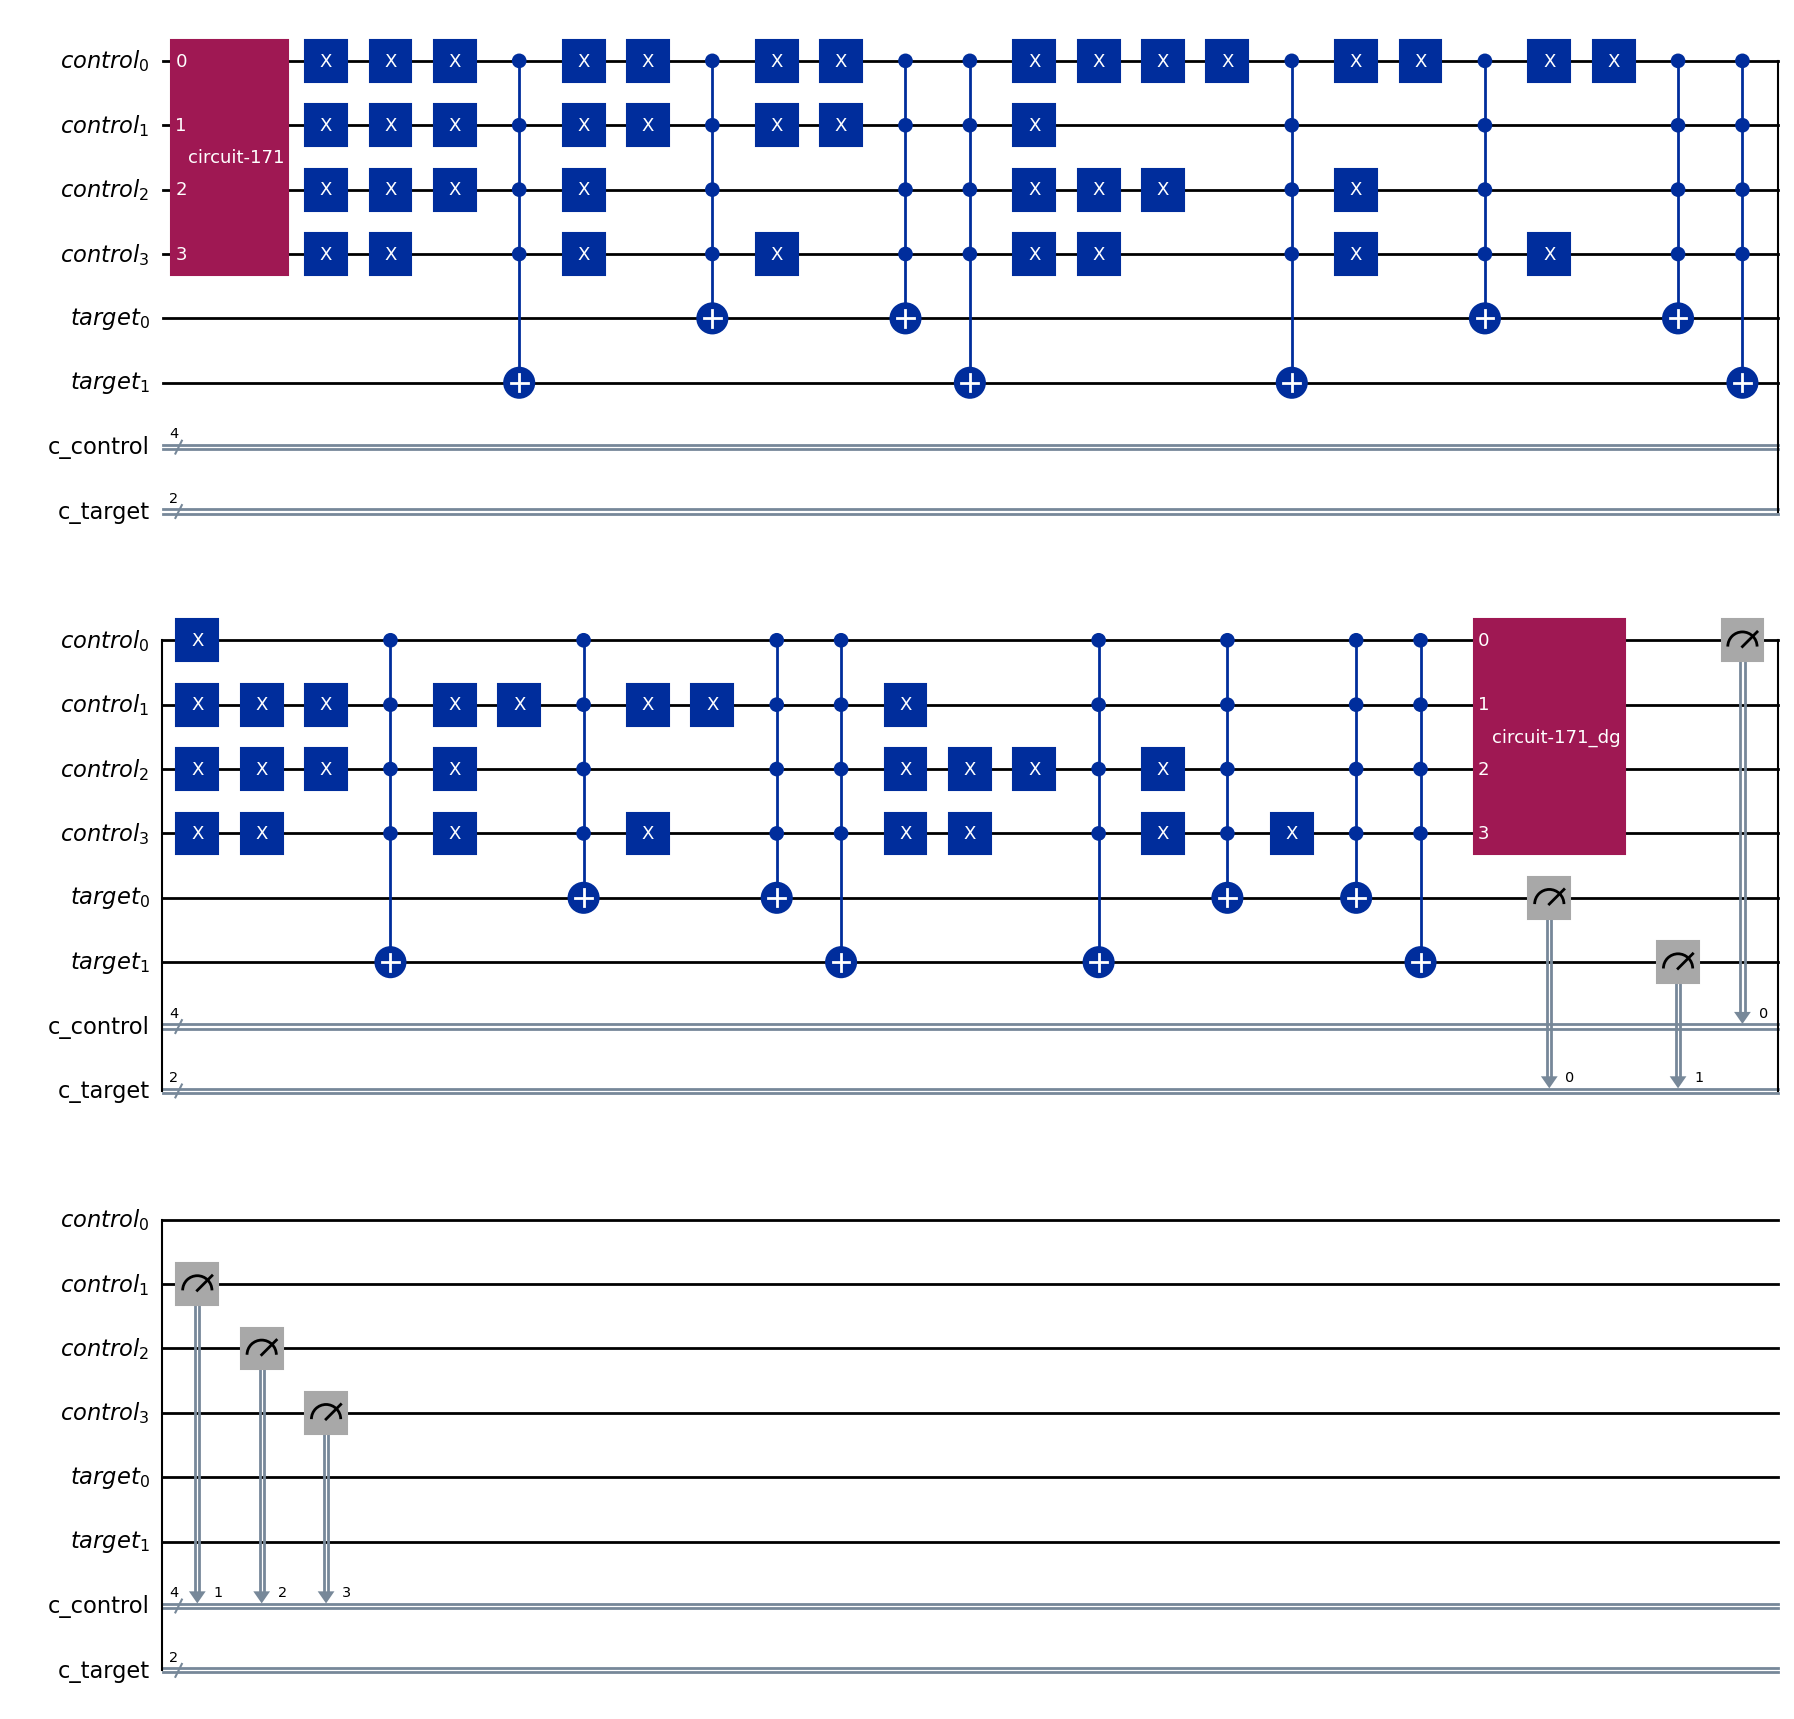

In [11]:
qc.draw('mpl')